In [1]:
!pip install --quiet yfinance
!pip install --quiet alphalens

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!mkdir -p sentiments
!cp drive/MyDrive/nlp/sentiments/* sentiments

In [4]:
!cp drive/MyDrive/nlp/deps/prices.py .
!cp drive/MyDrive/nlp/deps/plotter.py .

In [5]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm
import yfinance as yf
import alphalens as al

from prices import read_stock_prices
from plotter import plot

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
vader_df = pd.concat([pd.read_csv('sentiments/stocks_vader_mean_sentiment.csv'), 
                     pd.read_csv('sentiments/memestocks_vader_mean_sentiment.csv')])
print(vader_df.shape)
vader_df.Stock.unique()

(720, 3)


array(['AAPL', 'PLTR', 'TSLA', 'AMC', 'GME', 'NOK'], dtype=object)

In [7]:
roberta_reddit_df = pd.read_csv("sentiments/reddit-roberta-sentiment.csv", index_col=0)
roberta_twittr_df = pd.read_csv("sentiments/roberta-sentiment.csv", index_col=0)

print((roberta_reddit_df.shape, roberta_twittr_df.shape))
print(roberta_reddit_df.Stock.unique())
print(roberta_twittr_df.Stock.unique())

((619, 3), (348, 3))
['AMC' 'GME' 'NOK' 'PLTR' 'TSLA' 'AAPL']
['AAPL' 'TSLA' 'PLTR']


## Prices

In [8]:
stocks = ["AAPL", "TSLA", "PLTR", "NOK"]
price_data = read_stock_prices(stocks)

print(price_data.shape)
print(price_data.Stock.unique())

(388, 3)
['AAPL' 'TSLA' 'PLTR' 'NOK']


## Alphalens

In [9]:
def getFactorReturnsCumprod(sentiments, stockPrices, convertDate = False):
    # keep only stocks for which price data is available
    sentimentsFiltered = sentiments[sentiments.Stock.isin(stockPrices.Stock.unique())]

    if convertDate:
        sentimentsFiltered['Date'] = sentimentsFiltered['Date'].astype('datetime64[ns]')

    df = pd.merge(sentimentsFiltered, price_data, how = "left", on = ["Date", "Stock"])
    df.dropna(inplace = True)

    sentiment_df = df.pivot(index='Date', columns='Stock', values='Sentiment')
    prices = stockPrices.pivot(index='Date', columns='Stock', values='Close')

    clean_factor = al.utils.get_clean_factor_and_forward_returns(
        sentiment_df.stack(), 
        prices, 
        quantiles=5, 
        bins=None, 
        periods=[1]
    )

    returns_data = al.performance.factor_returns(clean_factor).iloc[:, 0]
    
    return (1 + returns_data).cumprod()


Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Dropped 4.1% entries from factor data: 0.0% in forward returns computation and 4.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


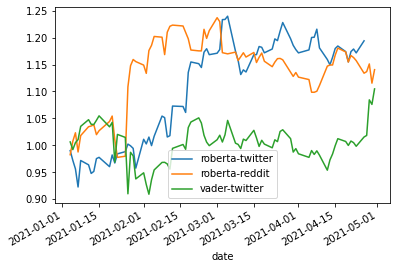

In [10]:
getFactorReturnsCumprod(roberta_twittr_df, price_data, convertDate=True).plot()
getFactorReturnsCumprod(roberta_reddit_df, price_data, convertDate=True).plot()
getFactorReturnsCumprod(vader_df, price_data, convertDate=True).plot()

plt.legend([
            "roberta-twitter",
            "roberta-reddit",
            "vader-twitter"
])
